<pre><font size=6>Spoken Digit Recognition</font></pre>

<pre>
Input - speech signal, output - digit number

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below.
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  
</pre>

In [ ]:
import os
if 'recordings.zip' not in os.listdir(): 
    !wget https://www.dropbox.com/s/3o07dl8cemw887v/recordings.zip
    get_ipython().system_raw("7z x recordings.zip")

In [ ]:
import numpy as np
import pandas as pd
import librosa
import os
from os import path

from tqdm.notebook import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')
##if you need any imports you can do that here. 

Mounted at /content/drive


In [ ]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
root = pathlib.Path("recordings")
rec_paths = list(root.rglob("*.wav*"))
all_files = [str(path) for path in rec_paths]

In [ ]:
len(all_files)

2000

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [ ]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0
label_lst = []
for p in all_files:
    label_name =  int(p.split("/")[1].split("_")[0])
    label_lst.append(label_name)
df_audio = pd.DataFrame(list(zip(all_files, label_lst)), columns =['path', 'label'])

In [ ]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [ ]:
df_audio.head()

,path,label
766,recordings/4_yweweler_47.wav,4
182,recordings/3_yweweler_26.wav,3
1763,recordings/4_nicolas_25.wav,4
1814,recordings/9_yweweler_43.wav,9
596,recordings/4_yweweler_15.wav,4


In [ ]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
X = df_audio['path']
y = df_audio['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=45)

In [ ]:
for i in X_train:
    print(i)
    break

recordings/6_yweweler_26.wav


<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [ ]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [ ]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
X_train_processed_lst = []
X_test_processed_lst = []

for path in tqdm(X_train):
    s_d = load_wav(path)
    X_train_processed_lst.append(s_d)

for path in tqdm(X_test):
    s_d = load_wav(path)
    X_test_processed_lst.append(s_d)

In [ ]:
X_train_processed = pd.DataFrame(X_train_processed_lst, columns =['raw_data', 'duration'])
X_test_processed = pd.DataFrame(X_test_processed_lst, columns =['raw_data', 'duration'])

In [ ]:
X_train.iloc[3]

'recordings/5_theo_28.wav'

In [ ]:
load_wav('recordings/5_yweweler_17.wav')

[array([ 1.5782520e-04,  1.6368195e-04,  1.6087637e-04, ...,
        -5.7159035e-05, -4.8506179e-05,  0.0000000e+00], dtype=float32),
 0.2821315192743764]

In [ ]:
X_train_processed_lst[3]

[array([-0.00067993, -0.0014941 , -0.00177168, ..., -0.00064158,
        -0.00043909,  0.        ], dtype=float32), 0.3805442176870748]

In [ ]:
X_train_processed.head()

,raw_data,duration
0,"[-0.00021709508, -0.00028584333, -0.0003213715...",0.192789
1,"[0.00024565606, 0.00023941231, 0.00021052365, ...",0.339501
2,"[9.440214e-05, 0.00016939559, 0.00022562861, 0...",0.279637
3,"[-0.00067992735, -0.0014940997, -0.00177168, -...",0.380544
4,"[0.00018011512, 0.00013778498, 4.1579457e-05, ...",0.370884


In [ ]:
X_test_processed.head()

,raw_data,duration
0,"[2.7298905e-05, -0.00042524404, -0.00047223858...",0.245034
1,"[-0.012453565, -0.011977133, -0.008346662, -0....",0.369388
2,"[0.0012325012, 0.0051624463, 0.007153227, 0.00...",0.225170
3,"[-0.0071184835, -0.010403867, -0.010893734, -0...",0.470385
4,"[0.00028326915, 0.0003435616, 0.0003327661, 0....",0.446395


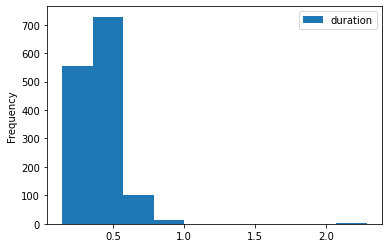

In [ ]:
#plot the histogram of the duration for trian
X_train_processed.plot.hist('duration')

In [ ]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0,101,10):
    print(i,"th percentile is",np.percentile(X_train_processed[['duration']].values, i))

0 th percentile is 0.1436281179138322
10 th percentile is 0.2581269841269841
20 th percentile is 0.3010884353741497
30 th percentile is 0.33136961451247166
40 th percentile is 0.35846712018140586
50 th percentile is 0.3907256235827664
60 th percentile is 0.4185578231292517
70 th percentile is 0.4470702947845805
80 th percentile is 0.48386394557823137
90 th percentile is 0.5536734693877551
100 th percentile is 2.282766439909297


In [ ]:
##print 90 to 100 percentile values with step size of 1. 
for i in range(90,101):
    print(i,"th percentile is",np.percentile(X_train_processed[['duration']].values, i))

90 th percentile is 0.5536734693877551
91 th percentile is 0.5642412698412701
92 th percentile is 0.5761396825396827
93 th percentile is 0.5864027210884358
94 th percentile is 0.6033333333333333
95 th percentile is 0.6208095238095238
96 th percentile is 0.6379374149659863
97 th percentile is 0.6549514739229023
98 th percentile is 0.6822975056689342
99 th percentile is 0.7908185941043082
100 th percentile is 2.282766439909297


In [ ]:
# printing 99 to 100 percentile values with step size of 0.1
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,"th percentile is",np.percentile(X_train_processed[['duration']].values, i))

99.1 th percentile is 0.8114687528344657
99.2 th percentile is 0.8204019954648525
99.3 th percentile is 0.8279474829931972
99.4 th percentile is 0.8419322448979643
99.5 th percentile is 0.8556700680272102
99.6 th percentile is 0.8604631292517007
99.7 th percentile is 0.8644408616780039
99.8 th percentile is 0.871304671201814
99.9 th percentile is 1.6707764625851824
100 th percentile is 2.282766439909297


<pre>Based on the above analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [ ]:
max_length  = 17640

In [ ]:
# Creating Padding
def pad_sequence(data, max_length): # This 'data' will be a pandas Series
    X_pad_seq = []
    for idx in range(len(data)):
        truncated = data[idx][:max_length]
        pad_this_much = max_length - len(truncated)
        X_pad_seq.append(np.pad(truncated, ((0,pad_this_much)), mode='constant', constant_values=0))
    X_pad_seq = np.array(X_pad_seq)
    return X_pad_seq

# Creating Mask
def mask_padded_sequence(padded_sequence):
    unmasked_embedding = tf.cast(tf.tile(tf.expand_dims(padded_sequence, axis=-1), [1, 1, 1]), tf.float32)
    masked_embedding  = tf.keras.layers.Masking()(unmasked_embedding)
    X_train_mask = masked_embedding._keras_mask
    return X_train_mask

In [ ]:
X_train_pad_seq = pad_sequence(X_train_processed['raw_data'], max_length)
X_test_pad_seq = pad_sequence(X_test_processed['raw_data'], max_length)

X_train_mask = mask_padded_sequence(X_train_pad_seq)
X_test_mask = mask_padded_sequence(X_test_pad_seq)

# **1. Giving Raw data directly** 

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. Read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer and then give it to Dense layer of size 10 (because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). 

</pre>

In [ ]:
## as discussed above, please write the LSTM
tf.keras.backend.clear_session()

input_X = Input(shape=(max_length,1), name="Input_X")
input_mask = Input(shape=max_length, name="Input_Mask", dtype='bool')
lstm = LSTM(units=64)(inputs=input_X, mask=input_mask)
dense = Dense(units=32, activation='relu')(lstm)
dense = BatchNormalization()(dense)
output = Dense(units=10, activation='softmax', name="Output")(dense)

model = Model(inputs=[input_X,input_mask], outputs=output)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_X (InputLayer)            [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
Input_Mask (InputLayer)         [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 64)           16896       Input_X[0][0]                    
                                                                 Input_Mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           2080        lstm[0][0]            

In [ ]:
# For more info on ModelCheckpoint, refer https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from tensorflow.keras.callbacks import ModelCheckpoint
model_path = "BEST_MODEL_1.hdfs"
checkpoint_1 = ModelCheckpoint(filepath=model_path, monitor='val_micro_f1',verbose=1, mode='max', save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau
# https://stackoverflow.com/a/42963385/7697658
lrschedule_1 = ReduceLROnPlateau(monitor='val_micro_f1', patience=2, mode='max', verbose=1, factor=0.50)

import datetime
log_dir="logs/1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average = 'micro')
    
def micro_f1(y_true, y_proba):
    y_pred = tf.math.argmax(y_proba,axis=1)
    return tf.py_function(f1_score_micro, (y_true,y_pred), tf.double)

In [ ]:
!rm -r logs
!rm -r model_1_checkpoint

In [ ]:
#train your model
#callbacks=[lrschedule_1, checkpoint_1, tensorboard_callback]
#validation_data=((X_test_pad_seq,X_test_mask), y_test)
#X_train_pad_seq, X_train_mask, X_test_pad_seq, X_test_mask
opt = Adam(0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=[micro_f1])
model.fit(x=[X_train_pad_seq,X_train_mask], y=y_train, validation_data=([X_test_pad_seq,X_test_mask], y_test), \
          epochs=10, verbose=True, callbacks=[lrschedule_1, checkpoint_1, tensorboard_callback])

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 2.3038 - micro_f1: 0.0793
Epoch 00001: val_micro_f1 improved from -inf to 0.10088, saving model to BEST_MODEL_1.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_1.hdfs/assets
44/44 [==============================] - 43s 967ms/step - loss: 2.3038 - micro_f1: 0.0793 - val_loss: 2.3027 - val_micro_f1: 0.1009
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 2.3018 - micro_f1: 0.0843
Epoch 00002: val_micro_f1 did not improve from 0.10088
44/44 [==============================] - 32s 738ms/step - loss: 2.3018 - micro_f1: 0.0843 - val_loss: 2.3029 - val_micro_f1: 0.0998
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 2.3024 - micro_f1: 0.0959
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_micro_f1 did not improve from 0.10088
44/44 [==============================] - 32s 717ms/step - loss: 2.3024 - micro_f1: 0.0959 - val_loss: 2.3030 - v

In [ ]:
!zip -r logs.zip logs

In [ ]:
best_model_1 = tf.keras.models.load_model('BEST_MODEL_1.hdfs', custom_objects={'f1_score_micro':f1_score_micro,'micro_f1':micro_f1})
best_f1_model_1 = best_model_1.evaluate([X_test_pad_seq,X_test_mask], y_test)[1]
print("Best Micro F1 score model 1=",best_f1_model_1)

19/19 [==============================] - 6s 298ms/step - loss: 2.3028 - micro_f1: 0.1250
Best Micro F1 score model 1= 0.125


# **2. Converting into spectrogram and giving spectrogram data as input**  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. read more about this in <a href=https://pnsn.org/spectrograms/what-is-a-spectrogram>https://pnsn.org/spectrograms/what-is-a-spectrogram</a>
</pre>

In [ ]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [ ]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad_seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
def get_spectogram_data(X_pad_seq):
    X_spectrogram = []
    for raw_data in tqdm(X_pad_seq):
        spectogram_data = convert_to_spectrogram(raw_data)
        X_spectrogram.append(spectogram_data)
    return np.array(X_spectrogram)


X_train_pad_seq = pad_sequence(X_train_processed['raw_data'], max_length)
X_test_pad_seq = pad_sequence(X_test_processed['raw_data'], max_length)

X_train_spectrogram = get_spectogram_data(X_train_pad_seq)
X_test_spectrogram = get_spectogram_data(X_test_pad_seq)

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy. 
</pre>

In [ ]:
tf.keras.backend.clear_session()

input_X = Input(shape=(64,35), name="Input_X")
lstm = LSTM(units=128, return_sequences=True)(inputs=input_X)
print(lstm.shape)
lstm = tf.expand_dims(lstm, axis=1)
print(lstm.shape)
lstm = tf.transpose(lstm, perm=[0,1,3,2])
print(lstm.shape)
avg_timesteps = GlobalAveragePooling2D()(lstm)
print(avg_timesteps.shape)
avg_timesteps = BatchNormalization()(avg_timesteps)
dense = Dense(units=64, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=0), kernel_regularizer=regularizers.l2())(avg_timesteps)
output = Dense(units=10, activation='softmax', name="Output")(dense)

model = Model(inputs=input_X, outputs=output)

(None, 64, 128)
(None, 1, 64, 128)
(None, 1, 128, 64)
(None, 64)


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_X (InputLayer)         [(None, 64, 35)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 128)           83968     
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 1, 64, 128)]      0         
_________________________________________________________________
tf_op_layer_Transpose (Tenso [(None, 1, 128, 64)]      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 64)               

In [ ]:
# For more info on ModelCheckpoint, refer https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from tensorflow.keras.callbacks import ModelCheckpoint
model_path = "BEST_MODEL_2.hdfs"
checkpoint_1 = ModelCheckpoint(filepath=model_path, monitor='val_micro_f1',verbose=1, mode='max', save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau
# https://stackoverflow.com/a/42963385/7697658
lrschedule_1 = ReduceLROnPlateau(monitor='val_micro_f1', min_lr=0.000001, patience=2, mode='max', verbose=1, factor=0.50)

import datetime
log_dir="logs/2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average = 'micro')
    
def micro_f1(y_true, y_proba):
    y_pred = tf.math.argmax(y_proba,axis=1)
    return tf.py_function(f1_score_micro, (y_true,y_pred), tf.float32)

In [ ]:
!rm -r logs
!rm -r model_2_checkpoint

In [ ]:
#train your model
#callbacks=[lrschedule_1, checkpoint_1, tensorboard_callback]
#validation_data=((X_test_pad_seq,X_test_mask), y_test)
#X_train_spectrogram, X_train_mask, X_test_spectrogram, X_test_mask
opt = Adam(0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=[micro_f1])
model.fit(x=X_train_spectrogram, y=y_train, validation_data=(X_test_spectrogram, y_test), \
          epochs=100, verbose=True, callbacks=[lrschedule_1, checkpoint_1, tensorboard_callback])

Epoch 1/100
43/44 [============================>.] - ETA: 0s - loss: 2.6917 - micro_f1: 0.2500
Epoch 00001: val_micro_f1 improved from -inf to 0.26700, saving model to BEST_MODEL_2.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_2.hdfs/assets
44/44 [==============================] - 5s 114ms/step - loss: 2.6863 - micro_f1: 0.2538 - val_loss: 2.8029 - val_micro_f1: 0.2670
Epoch 2/100
40/44 [==========================>...] - ETA: 0s - loss: 2.0228 - micro_f1: 0.4828
Epoch 00002: val_micro_f1 improved from 0.26700 to 0.28070, saving model to BEST_MODEL_2.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_2.hdfs/assets
44/44 [==============================] - 5s 119ms/step - loss: 1.9932 - micro_f1: 0.4950 - val_loss: 2.6613 - val_micro_f1: 0.2807
Epoch 3/100
43/44 [============================>.] - ETA: 0s - loss: 1.5693 - micro_f1: 0.6417
Epoch 00003: val_micro_f1 improved from 0.28070 to 0.33717, saving model to BEST_MODEL_2.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_2.hdfs/a

In [ ]:
!zip -r logs.zip logs

In [ ]:
best_model_2 = tf.keras.models.load_model('BEST_MODEL_2.hdfs', custom_objects={'f1_score_micro':f1_score_micro,'micro_f1':micro_f1})
best_f1_model_2 = best_model_2.evaluate(X_test_spectrogram, y_test)[1]
print("Best Micro F1 score model 2=",best_f1_model_2)

19/19 [==============================] - 0s 5ms/step - loss: 0.3966 - micro_f1: 0.9507
Best Micro F1 score model 2= 0.9506579041481018


# **3. Data Augmentation**  
<pre>
Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [ ]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path, get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [ ]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [ ]:
len(aug_temp)

9

In [ ]:
def augment_data(X_data, y_data):    # 'X_data' is the data with the paths of the recordings
    X_augmented = []
    y_augmented = []
    for path, label in tqdm(zip(X_data, y_data)):
        sample_aug = generate_augmented_data(path)
        X_augmented.extend(sample_aug)
        y_augmented.extend([label]*9)

    return np.array(X_augmented), np.array(y_augmented)

### **3.1 Raw Data Augmentation**  

In [ ]:
# X_train_augmented, y_train_augmented = augment_data(X_train, y_train)
# X_test_augmented, y_test_augmented = augment_data(X_test, y_test)

# # Saving the pickels
# # ------------------
# pkl_path = "/content/drive/My Drive/Colab Notebooks/Spoken Digit Recognition/Raw augmented pickles/"
# np.save(pkl_path+'X_train_augmented', X_train_augmented)
# np.save(pkl_path+'y_train_augmented', y_train_augmented)
# np.save(pkl_path+'X_test_augmented', X_test_augmented)
# np.save(pkl_path+'y_test_augmented', y_test_augmented)

In [ ]:
## Loading the pickels
## -------------------
pkl_path = "/content/drive/My Drive/Colab Notebooks/Spoken Digit Recognition/Raw augmented pickles/"
X_train_augmented = np.load(pkl_path+'X_train_augmented.npy', allow_pickle=True)
y_train_augmented = np.load(pkl_path+'y_train_augmented.npy', allow_pickle=True)
X_test_augmented = np.load(pkl_path+'X_test_augmented.npy', allow_pickle=True)
y_test_augmented = np.load(pkl_path+'y_test_augmented.npy', allow_pickle=True)

In [ ]:
print(len(X_train_augmented))
print(len(y_train_augmented))
print(len(X_test_augmented))
print(len(y_test_augmented))

12600
12600
5400
5400


In [ ]:
# max_length = 17640
X_train_padded_aug = pad_sequence(X_train_augmented, max_length)
X_test_padded_aug = pad_sequence(X_test_augmented, max_length)

X_train_mask_aug = mask_padded_sequence(X_train_padded_aug)
X_test_mask_aug = mask_padded_sequence(X_test_padded_aug)

As discussed above, for one data point, we will get 9 augmented data points.  
We have 2000 data points(train plus test) so, after augmentation we will get 18000 ( train - 12600, test - 5400). 

do the above steps i.e training with raw data and spectrogram data with augmentation.

In [ ]:
print(X_train_padded_aug.shape)
print(X_train_mask_aug.shape)
print(X_test_padded_aug.shape)
print(X_test_mask_aug.shape)

(12600, 17640)
(12600, 17640)
(5400, 17640)
(5400, 17640)


In [ ]:
# Create model
tf.keras.backend.clear_session()

input_X = Input(shape=(max_length,1))
input_mask = Input(shape=max_length, dtype='bool')
lstm = LSTM(units=64)(inputs=input_X, mask=input_mask)
dense = Dense(units=32, activation='relu')(lstm)
dense = BatchNormalization()(dense)
output = Dense(units=10, activation='softmax', name="Output")(dense)

model = Model(inputs=[input_X,input_mask], outputs=output)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 64)           16896       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           2080        lstm[0][0]            

In [ ]:
# For more info on ModelCheckpoint, refer https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from tensorflow.keras.callbacks import ModelCheckpoint
model_path = "BEST_MODEL_3.hdfs"
checkpoint_1 = ModelCheckpoint(filepath=model_path, monitor='val_micro_f1',verbose=1, mode='max', save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau
# https://stackoverflow.com/a/42963385/7697658
lrschedule_1 = ReduceLROnPlateau(monitor='val_micro_f1', patience=2, mode='max', verbose=1, factor=0.50)

import datetime
log_dir="logs/3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average = 'micro')
    
def micro_f1(y_true, y_proba):
    y_pred = tf.math.argmax(y_proba,axis=1)
    return tf.py_function(f1_score_micro, (y_true,y_pred), tf.double)

In [ ]:
!rm -r logs

In [ ]:
#train your model

opt = Adam(0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=[micro_f1])
model.fit(x=[X_train_padded_aug,X_train_mask_aug], y=y_train_augmented, validation_data=([X_test_padded_aug,X_test_mask_aug], y_test_augmented), \
          epochs=10, verbose=True, callbacks=[lrschedule_1, checkpoint_1, tensorboard_callback])

Epoch 1/10
394/394 [==============================] - ETA: 0s - loss: 2.3033 - micro_f1: 0.1003
Epoch 00001: val_micro_f1 improved from -inf to 0.10022, saving model to BEST_MODEL_3.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_3.hdfs/assets
394/394 [==============================] - 349s 885ms/step - loss: 2.3033 - micro_f1: 0.1003 - val_loss: 2.3042 - val_micro_f1: 0.1002
Epoch 2/10
394/394 [==============================] - ETA: 0s - loss: 2.3031 - micro_f1: 0.1030
Epoch 00002: val_micro_f1 did not improve from 0.10022
394/394 [==============================] - 335s 851ms/step - loss: 2.3031 - micro_f1: 0.1030 - val_loss: 2.3190 - val_micro_f1: 0.0999
Epoch 3/10
394/394 [==============================] - ETA: 0s - loss: 2.3030 - micro_f1: 0.1022
Epoch 00003: val_micro_f1 improved from 0.10022 to 0.10041, saving model to BEST_MODEL_3.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_3.hdfs/assets
394/394 [==============================] - 347s 881ms/step - loss: 2.3030 - micro_

In [ ]:
best_model_3 = tf.keras.models.load_model('BEST_MODEL_3.hdfs', custom_objects={'f1_score_micro':f1_score_micro,'micro_f1':micro_f1})
best_f1_model_3 = best_model_3.evaluate([X_test_padded_aug,X_test_mask_aug], y_test_augmented)[1]
print("Best Micro F1 score model 3=", best_f1_model_3)

169/169 [==============================] - 52s 306ms/step - loss: 6.2611 - micro_f1: 0.1004
Best Micro F1 score model 3= 0.10040680319070816


### **3.2 Spectogram Data Augmentation**  

In [ ]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [ ]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path, get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [ ]:
def augment_data(X_data, y_data):    # 'X_data' is the data with the paths of the recordings
    X_augmented = []
    y_augmented = []
    for path, label in tqdm(zip(X_data, y_data)):
        sample_aug = generate_augmented_data(path)
        X_augmented.extend(sample_aug)
        y_augmented.extend([label]*9)

    return np.array(X_augmented), np.array(y_augmented)

In [ ]:
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)
X_test_augmented, y_test_augmented = augment_data(X_test, y_test)

X_train_pad_seq = pad_sequence(X_train_augmented, max_length)
X_test_pad_seq = pad_sequence(X_test_augmented, max_length)

X_train_spectrogram = get_spectogram_data(X_train_pad_seq)
X_test_spectrogram = get_spectogram_data(X_test_pad_seq)

In [ ]:
tf.keras.backend.clear_session()

input_X = Input(shape=(64,35), name="Input_X")
lstm = LSTM(units=128, return_sequences=True)(inputs=input_X)
print(lstm.shape)
lstm = tf.expand_dims(lstm, axis=1)
print(lstm.shape)
lstm = tf.transpose(lstm, perm=[0,1,3,2])
print(lstm.shape)
avg_timesteps = GlobalAveragePooling2D()(lstm)
print(avg_timesteps.shape)
avg_timesteps = BatchNormalization()(avg_timesteps)
dense = Dense(units=64, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=0), kernel_regularizer=regularizers.l2())(avg_timesteps)
output = Dense(units=10, activation='softmax', name="Output")(dense)

model = Model(inputs=input_X, outputs=output)

(None, 64, 128)
(None, 1, 64, 128)
(None, 1, 128, 64)
(None, 64)


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_X (InputLayer)         [(None, 64, 35)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 128)           83968     
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 1, 64, 128)]      0         
_________________________________________________________________
tf_op_layer_Transpose (Tenso [(None, 1, 128, 64)]      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 64)               

In [ ]:
# For more info on ModelCheckpoint, refer https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from tensorflow.keras.callbacks import ModelCheckpoint
model_path = "BEST_MODEL_4.hdfs"
checkpoint_1 = ModelCheckpoint(filepath=model_path, monitor='val_micro_f1',verbose=1, mode='max', save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau
# https://stackoverflow.com/a/42963385/7697658
lrschedule_1 = ReduceLROnPlateau(monitor='val_micro_f1', min_lr=0.000001, patience=2, mode='max', verbose=1, factor=0.50)

import datetime
log_dir="logs/4/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average = 'micro')
    
def micro_f1(y_true, y_proba):
    y_pred = tf.math.argmax(y_proba,axis=1)
    return tf.py_function(f1_score_micro, (y_true,y_pred), tf.float32)

In [ ]:
!rm -r logs

In [ ]:
#train your model
#callbacks=[lrschedule_1, checkpoint_1, tensorboard_callback]
#validation_data=((X_test_pad_seq,X_test_mask), y_test)
#X_train_spectrogram, X_train_mask, X_test_spectrogram, X_test_mask
opt = Adam(0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=[micro_f1])
model.fit(x=X_train_spectrogram, y=y_train_augmented, validation_data=(X_test_spectrogram, y_test_augmented), \
          epochs=80, verbose=True, callbacks=[lrschedule_1, checkpoint_1, tensorboard_callback])

Epoch 1/80
390/394 [============================>.] - ETA: 0s - loss: 1.5729 - micro_f1: 0.5885
Epoch 00001: val_micro_f1 improved from -inf to 0.36089, saving model to BEST_MODEL_4.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_4.hdfs/assets
394/394 [==============================] - 10s 26ms/step - loss: 1.5680 - micro_f1: 0.5898 - val_loss: 2.0028 - val_micro_f1: 0.3609
Epoch 2/80
390/394 [============================>.] - ETA: 0s - loss: 0.8200 - micro_f1: 0.7946
Epoch 00002: val_micro_f1 improved from 0.36089 to 0.62130, saving model to BEST_MODEL_4.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_4.hdfs/assets
394/394 [==============================] - 9s 22ms/step - loss: 0.8190 - micro_f1: 0.7951 - val_loss: 1.0985 - val_micro_f1: 0.6213
Epoch 3/80
394/394 [==============================] - ETA: 0s - loss: 0.6993 - micro_f1: 0.8183
Epoch 00003: val_micro_f1 improved from 0.62130 to 0.74581, saving model to BEST_MODEL_4.hdfs
INFO:tensorflow:Assets written to: BEST_MODEL_4.

In [ ]:
!zip -r logs.zip logs

In [ ]:
best_model_4 = tf.keras.models.load_model('BEST_MODEL_4.hdfs', custom_objects={'f1_score_micro':f1_score_micro,'micro_f1':micro_f1})
best_f1_model_4 = best_model_4.evaluate(X_test_spectrogram, y_test_augmented)[1]
print("Best Micro F1 score model 4=", best_f1_model_4)

169/169 [==============================] - 1s 6ms/step - loss: 0.2828 - micro_f1: 0.9392
Best Micro F1 score model 4= 0.9392258524894714


In [ ]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["Model no.", "Model Description", "Test Micro F1"]

pt.add_row(["Model 1", "Raw Data", round(best_f1_model_1,4)])
pt.add_row(["Model 2", "Spectogram", round(best_f1_model_2,4)])
pt.add_row(["Model 3", "Raw Data Augmented", round(best_f1_model_3,4)])
pt.add_row(["Model 4", "Spectogram Augmented", round(best_f1_model_4,4)])

print(pt)

+-----------+----------------------+---------------+
| Model no. |  Model Description   | Test Micro F1 |
+-----------+----------------------+---------------+
|  Model 1  |       Raw Data       |     0.125     |
|  Model 2  |      Spectogram      |     0.9507    |
|  Model 3  |  Raw Data Augmented  |     0.1004    |
|  Model 4  | Spectogram Augmented |     0.9392    |
+-----------+----------------------+---------------+


# <font color='purple'>**Observations**</font>

<ul>
<li>The data we have is in <b>Audio format</b>. To work on audio data, we need to convert it into numeric data by <b>sampling</b> it using a sampling rate.</li>
<li>As any audio is sequential in nature, we can make use of <b>LSTM</b> in this case. The Audios are of various lengths, however LSTM cannot work with variable length input sequences. Hence, after doing an EDA, we found that 99% of the audios are of 0.8 seconds, and so we decided to keep the max sequence length as the 0.8 seconds. Converting into the samples, it comes out to be 17640.</li>
<li>We tried 4 different models, which are described as follows
    <ul>
        <li><b>Using Raw data:</b> We directly used the Raw samples from the audio. The work flow is as follows,<br>
        <a href="https://imgur.com/a/P6kGhh4/">
         <img alt="Raw data" src="https://i.imgur.com/AHfdECy.png"
         width="200" height="300">
      </a> <br>
      The raw data gave us the micro F1 score of 0.125, which is a poor score, and is almost like a random guess. 
        </li>
        <li><b>Using Spectogram data:</b> We used the Spectrogram data from the audio. The work flow is as follows,<br>
        <a href="https://imgur.com/a/BrVJkZM/">
         <img alt="Spectrogram data" src="https://i.imgur.com/yBEDu8i.png"
         width="250" height="500">
      </a><br>
      As we didn't get good enough F1 score using only the raw data, now we used the spectrogram data of the audios. The spectrogram data gave us the micro F1 score of 0.9507, which is a very good score.</li>
        <li><b>Augmenting Raw data:</b> We used the Augmented Raw samples from the audio. The work flow is as follows,<br>
        <a href="https://imgur.com/a/OmlUH06/">
         <img alt="Augmented Raw data" src="https://i.imgur.com/PwWXZYZ.png"
         width="200" height="400">
      </a><br>
      We tried to augment the raw data in this model. It gave us the micro F1 score of 0.1004, which is a poor score, and is almost like a random guess. </li>
        <li><b>Augmenting Spectogram data:</b> We used the Augmented Spectrogram data from the audio. The work flow is as follows,<br>
        <a href="https://imgur.com/a/FUCowY2/">
         <img alt="Augmented Spectrogram data" src="https://i.imgur.com/M6EIra4.png"
         width="250" height="500">
      </a><br>
      As we didn't get good enough F1 score using only the augmented raw data, now we augmented the spectrogram data of the audios. The augmented spectrogram data gave us the micro F1 score of 0.9392, which is a very good score.</li>
    </ul>
</li>
<li><b>Why does Spectrogram give better results?</b>
    <ul>
        <li>We saw that Spectrogram data of the audio is giving us better results as compared to using plain raw samples from the audio. This is because te spectrogram gives us a rich set of information/features such as pitch difference, volume, overtone, etc. which can help us better differentiate what is said in the audio. Whereas, the audio sampling (raw data) does not give us any of that information, and is just a series of numbers with no inherant features. </li>
    </ul>
</li>
</ul>